# **Initial Model Evaluation**

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    train_preds, train_labels = [], []

    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_preds.extend(outputs.argmax(1).cpu().numpy())
        train_labels.extend(y.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)

            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(y.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average="macro")

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, "
          f"Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

100%|██████████| 1403/1403 [16:51<00:00,  1.39it/s]


Epoch 1: Train Acc=0.6761, Val Acc=0.3373, Val F1=0.1652


 55%|█████▍    | 769/1403 [08:59<07:24,  1.42it/s]


KeyboardInterrupt: 

Initially, when I ran the training loop directly on raw audio files, I noticed it was taking an extremely long time to process each batch. Each audio sample had to be loaded from disk and converted to MFCCs on-the-fly, which caused the DataLoader to become a bottleneck. This made training 44,896 samples in each epoch very slow and sometimes forced me to manually interrupt the run. I realized that while the code was correct and the model would eventually train, the practical runtime was unmanageable for repeated experiments.

To address this, I switched to pre-extracting MFCC features for all training and validation samples. By aggregating the MFCCs into fixed-length vectors beforehand, I could feed the model numeric arrays directly instead of raw audio, which drastically reduced processing time and removed repeated on-the-fly computation. This approach preserved the same age-relevant feature representation while making training more efficient, reproducible, and stable, allowing me to iterate quickly and evaluate performance without unnecessary delays.

In [ ]:
from tqdm import tqdm

def extract_mfcc_features(dataframe, n_mfcc=40):
    features = []
    labels = []

    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        signal, sr = librosa.load(row["full_path"], sr=16000)

        mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc)

        feat = np.concatenate([
            np.mean(mfcc, axis=1),
            np.std(mfcc, axis=1)
        ])

        features.append(feat)
        labels.append(row["label"])

    return np.array(features), np.array(labels)

print("Extracting train MFCC...")
X_train, y_train = extract_mfcc_features(train_df)

print("Extracting val MFCC...")
X_val, y_val = extract_mfcc_features(val_df)

print("Feature shape:", X_train.shape)

Extracting train MFCC...


100%|██████████| 44896/44896 [13:13<00:00, 56.58it/s]


Extracting val MFCC...


100%|██████████| 7988/7988 [02:26<00:00, 54.50it/s]

Feature shape: (44896, 80)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train)
)

val_dataset = TensorDataset(
    torch.tensor(X_val, dtype=torch.float32),
    torch.tensor(y_val)
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [ ]:
model = MLP(input_dim=80, num_classes=num_classes).to(device)

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    model.train()
    train_preds, train_labels = [], []

    for x, y in tqdm(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        train_preds.extend(outputs.argmax(1).cpu().numpy())
        train_labels.extend(y.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)

    model.eval()
    val_preds, val_labels = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)

            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(y.cpu().numpy())

    val_acc = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average="macro")

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, "
          f"Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

100%|██████████| 702/702 [00:02<00:00, 293.68it/s]


Epoch 1: Train Acc=0.6442, Val Acc=0.3315, Val F1=0.1351


100%|██████████| 702/702 [00:01<00:00, 362.54it/s]


Epoch 2: Train Acc=0.7798, Val Acc=0.2972, Val F1=0.1577


100%|██████████| 702/702 [00:01<00:00, 463.85it/s]


Epoch 3: Train Acc=0.8305, Val Acc=0.2809, Val F1=0.1499


100%|██████████| 702/702 [00:01<00:00, 470.52it/s]


Epoch 4: Train Acc=0.8630, Val Acc=0.3015, Val F1=0.1600


100%|██████████| 702/702 [00:01<00:00, 456.78it/s]


Epoch 5: Train Acc=0.8898, Val Acc=0.2757, Val F1=0.1465


100%|██████████| 702/702 [00:01<00:00, 368.19it/s]


Epoch 6: Train Acc=0.9048, Val Acc=0.2986, Val F1=0.1504


100%|██████████| 702/702 [00:01<00:00, 463.41it/s]


Epoch 7: Train Acc=0.9202, Val Acc=0.2942, Val F1=0.1694


100%|██████████| 702/702 [00:01<00:00, 456.34it/s]


Epoch 8: Train Acc=0.9315, Val Acc=0.2854, Val F1=0.1554


100%|██████████| 702/702 [00:01<00:00, 468.68it/s]


Epoch 9: Train Acc=0.9399, Val Acc=0.2954, Val F1=0.1581


100%|██████████| 702/702 [00:01<00:00, 474.66it/s]


Epoch 10: Train Acc=0.9438, Val Acc=0.2780, Val F1=0.1556


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        outputs = model(x)
        preds = outputs.argmax(1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

val_acc = accuracy_score(all_labels, all_preds)
val_f1 = f1_score(all_labels, all_preds, average="macro")

print("Validation Accuracy:", val_acc)
print("Validation Macro F1:", val_f1)

Validation Accuracy: 0.27804206309464197
Validation Macro F1: 0.1555562578103091


In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=le.classes_))


Classification Report:
              precision    recall  f1-score   support

    eighties       0.00      0.00      0.00        10
     fifties       0.11      0.10      0.10       822
    fourties       0.38      0.46      0.41      1911
   seventies       0.14      0.02      0.04       363
     sixties       0.02      0.04      0.02       120
       teens       0.06      0.15      0.09       402
    thirties       0.21      0.17      0.19      1980
    twenties       0.42      0.36      0.39      2380

    accuracy                           0.28      7988
   macro avg       0.17      0.16      0.16      7988
weighted avg       0.29      0.28      0.28      7988



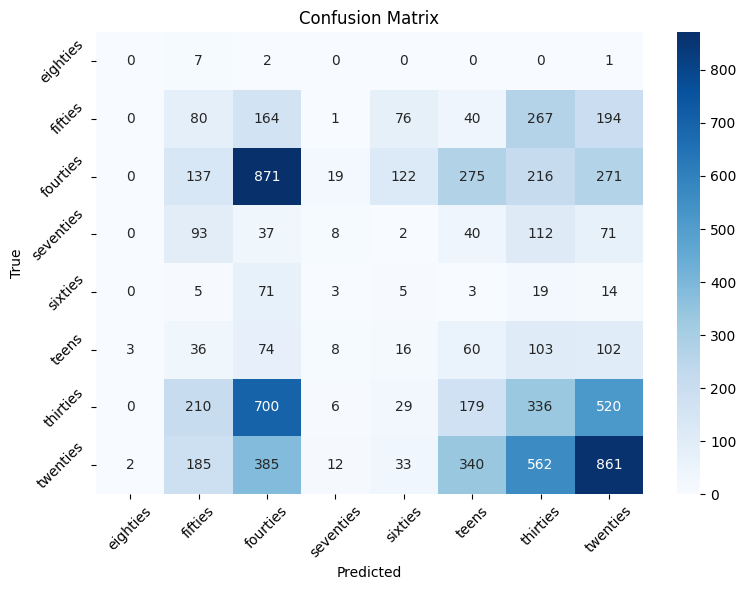

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap="Blues")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()